# Morphological Classification of Radio Galaxies with wGAN-supported Augmentation

https://arxiv.org/abs/2212.08504

In [1]:
import os
import h5py
import random
import numpy as np
import torch
import wGAN_models as models
import torchvision.transforms as transforms
from torchvision.datasets.utils import download_url
import matplotlib.pyplot as plt

### Configure meta data

In [2]:
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_str)

In [3]:
metadata = {'image_shape': [1, 128, 128],
             'nz': 100,
             'ngf': 64,
             'bsize': 100}

In [4]:
seed = 42
torch.manual_seed(seed)

### Define number of generated images

In [5]:
num_gen_img = 100

### Download checkpoint GANs

In [6]:
urls = {"generator_epoch_3361_iter_30250_cla0.pt": "https://zenodo.org/record/7685453/files/generator_epoch_3361_iter_30250_cla0.pt?download=1",
        "generator_epoch_3833_iter_34500_cla1.pt": "https://zenodo.org/record/7685453/files/generator_epoch_3833_iter_34500_cla1.pt?download=1",
        "generator_epoch_1305_iter_11750_cla2.pt": "https://zenodo.org/record/7685453/files/generator_epoch_1305_iter_11750_cla2.pt?download=1",
        "generator_epoch_4416_iter_39750_cla3.pt": "https://zenodo.org/record/7685453/files/generator_epoch_4416_iter_39750_cla3.pt?download=1",
}
# download file
for key in urls.keys():
    download_url(urls[key], os.getcwd(), key)

100.0%


100.0%


100.0%


100.0%


### Load generators

In [7]:
checkpoints = {
            0: "generator_epoch_3361_iter_30250_cla0.pt",
            1: "generator_epoch_3833_iter_34500_cla1.pt",
            2: "generator_epoch_1305_iter_11750_cla2.pt",
            3: "generator_epoch_4416_iter_39750_cla3.pt"
        }
generators = {k: models.Generator(metadata['nz'], 1, metadata['ngf'], 4).cpu() for k in checkpoints}
for label, checkpoint in checkpoints.items():
    generators[label].load_state_dict(torch.load(checkpoint, map_location=device))
    generators[label].eval();

### Generate images

In [8]:
def get_generated_images(generators, bsize, n_gen_images, nz, device):
    """
    n_gen_images has to be divisible by n_generators
    """

    tensor_opt = {'device': device, 'dtype': torch.float, 'requires_grad': False}
    onehot = torch.zeros(4, 4, **tensor_opt)
    onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3]).view(4, 1).to(device), 1).view(4, 4, 1, 1)

    generated_images = {k: torch.Tensor() for k in generators}
    gen_images_per_gen = n_gen_images // len(generators)
    for label_ind in generators.keys():
        img_counter = 0
        while img_counter < gen_images_per_gen:
            noise = torch.randn(bsize, nz, 1, 1, device=device, requires_grad=False)
            labels = torch.tensor([label_ind] * bsize, device=device, requires_grad=False)
            with torch.no_grad():
                res = ((generators[label_ind](noise, onehot[labels]) / 2 + .5) * 255).int().cpu()
                expected = img_counter + bsize
                if expected > gen_images_per_gen:
                    res = res[:gen_images_per_gen - img_counter]
                generated_images[label_ind] = res if generated_images[label_ind].shape[0] == 0 else torch.cat(
                    (generated_images[label_ind], res))
                img_counter += bsize

    return generated_images

In [9]:
res = get_generated_images(generators, metadata['nz'], num_gen_img, metadata['nz'], device)

In [10]:
gen_imgs = {k: torch.vstack([z for z in v]) for k,v in res.items()}

### Define threshold for each class

low value -> less pixels with intensity values within the image

high value -> more pixel with intensity values within the image (more complex galaxies)


In [11]:
thresholds = {
    0: 7500,  # 0,7500, 15000
    1: 7500,  # , 0, 7500 15000
    2: 2500,  # 0, 2500,5000
    3: 7500  # 0, 7500,15000
}

In [12]:
gen_sums = {k: v.sum((1,2)) for k,v in gen_imgs.items()}

In [13]:
thresh_gen_images = {k: gen_imgs[k][gen_sum > thresholds[k]] for k, gen_sum in gen_sums.items()}
thresh_gen_indices = {k: range(len(thresh_gen_images[k])) for k in range(4)}

In [14]:
tg0 = thresh_gen_images[0][thresh_gen_indices[0]].view(thresh_gen_images[0].size())
tg1 = thresh_gen_images[1][thresh_gen_indices[1]].view(thresh_gen_images[1].size())
tg2 = thresh_gen_images[2][thresh_gen_indices[2]].view(thresh_gen_images[2].size())
tg3 = thresh_gen_images[3][thresh_gen_indices[3]].view(thresh_gen_images[3].size())

## FRI

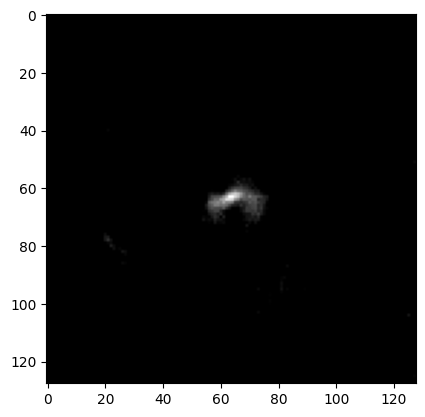

In [15]:
fri_gen_ind=0
plt.imshow(tg0[fri_gen_ind].cpu().detach().numpy(),cmap="gray")

## FRII

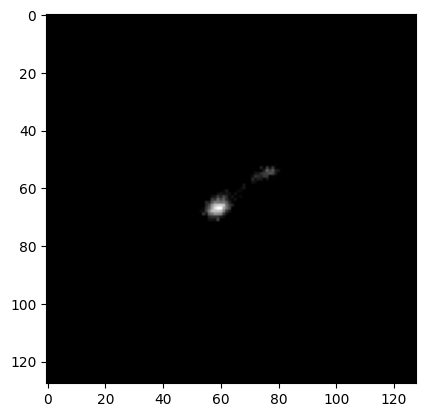

In [16]:
frii_gen_ind=0
plt.imshow(tg1[frii_gen_ind].cpu().detach().numpy(),cmap="gray")

## Compact

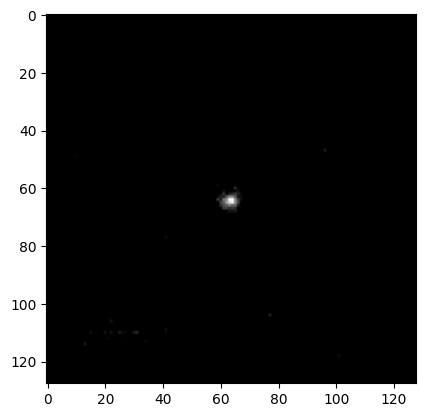

In [17]:
compact_gen_ind=0
plt.imshow(tg2[compact_gen_ind].cpu().detach().numpy(),cmap="gray")

## Bent

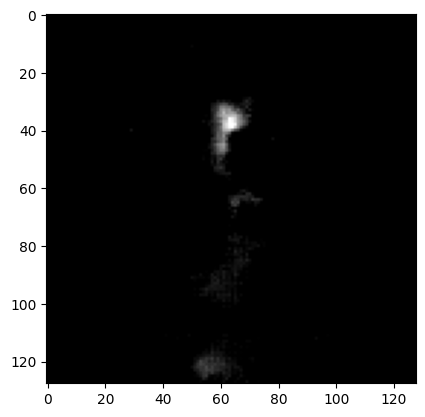

In [18]:
bent_gen_ind=0
plt.imshow(tg3[bent_gen_ind].cpu().detach().numpy(),cmap="gray")